In [1]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.covariance import X_mu, X_Sigmainv, logX_mu
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

In [2]:
format = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.fancybox': False,
    'legend.shadow': False
}
plt.rcParams.update(format)

Across an ensemble of NS runs, consider the point estimates of Z at the same point in each run - smoothing does better on average

How to get an errorbar for each point estimate?

Compare live evidence estimates

In [3]:
def evidence(L, X, live=True):
    if live:
        return -np.trapz(L, X) + X[-1] * L[-1]
    else:
        return -np.trapz(L, X)

from scipy.integrate import quad
def gaussian_L(X, theta):
    d, sigma = theta
    return np.exp(-X**(2/d)/(2*sigma**2))

Ztrue = quad(gaussian_L, 0, 1, [10, 0.1])[0]
Ztrue, np.log(Ztrue)

(3.839461497722952e-07, -14.772763529160507)

#### **Single instance**

In [513]:
ndead = 300
nlive = 100
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [514]:
Zlive_true = quad(gaussian_L, 0, X_mean[ndead], [10, 0.1])[0]
Zlive_true

3.8396754175251184e-07

In [515]:
Xtrue = generate_Xs(nk)
Xdead, Xlive = Xtrue[:ndead], Xtrue[ndead:]
logX = np.log(Xtrue)
theta_true = [10, 0.1]
logL = middle.func(Xtrue, theta_true)
L = np.exp(logL)
logLdead, logLlive = logL[:ndead], logL[ndead:]
Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

ls = LS(logL[ndead:], middle, X_mean[ndead:])
theta_l = ls.minimise(theta_true)
X_l = middle.inverse(logL, theta_l)
logX_l = np.log(X_l)

In [516]:
Zdead = evidence(Ldead, X_mean[:ndead])
Zlive_mean = evidence(Llive, X_mean[ndead:])
Zlive_smooth = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
logZmean = np.log(Zdead + Zlive_mean)
logZsmooth = np.log(Zdead + Zlive_smooth)
# print(logZmean, logZsmooth)
print(Zlive_mean, Zlive_smooth)

4.8632150947296644e-08 1.22146406895517e-06


#### **Ensemble performance**

In [274]:
ndead = 150
nlive = 100
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)

In [275]:
logZmeans = []
logZsmooths = []
for _ in range(20):
    Xtrue = generate_Xs(nk)
    Xdead, Xlive = Xtrue[:ndead], Xtrue[ndead:]
    logX = np.log(Xtrue)
    theta_true = [10, 0.1]
    logL = middle.func(Xtrue, theta_true)
    L = np.exp(logL)
    logLdead, logLlive = logL[:ndead], logL[ndead:]
    Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

    ls = LS(logL[ndead:], middle, X_mean[ndead:])
    theta_l = ls.minimise(theta_true)
    X_l = middle.inverse(logL, theta_l)
    logX_l = np.log(X_l)

    Zdead = evidence(Ldead, X_mean[:ndead])
    Zlive_mean = evidence(Llive, X_mean[ndead:])
    Zlive_smooth = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
    logZmean = np.log(Zdead + Zlive_mean)
    logZsmooth = np.log(Zdead + Zlive_smooth)
    logZmeans.append(np.log(Zlive_mean))
    logZsmooths.append(np.log(Zlive_smooth))

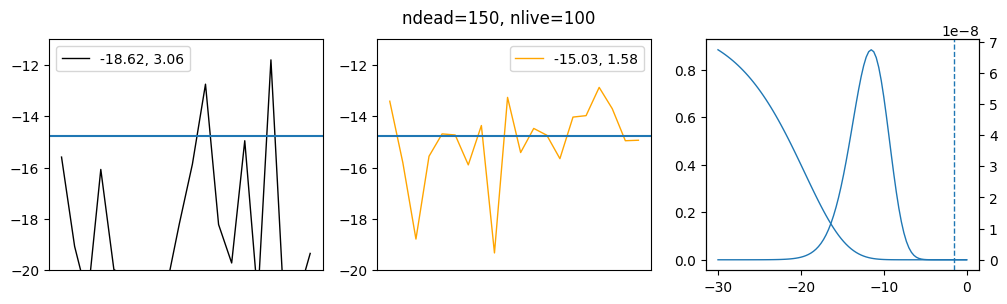

In [278]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 3))
ax1.plot(logZmeans, lw=1, color='black', label=f"{np.mean(logZmeans):.2f}, {np.std(logZmeans):.2f}")
ax2.plot(logZsmooths, lw=1, color='orange', label=f"{np.mean(logZsmooths):.2f}, {np.std(logZsmooths):.2f}")
for ax in [ax1, ax2]:
    ax.axhline(np.log(Zlive_true))
    ax.set_ylim(-20, -11)
    ax.set_xticks([])
    ax.legend()
ax4 = plt.twinx(ax3)
logXarray = np.linspace(-30, 0, 100)
Xarray = np.exp(logXarray)
ax3.plot(logXarray, gaussian_L(Xarray, [10, 0.1]), lw=1)
ax4.plot(logXarray, gaussian_L(Xarray, [10, 0.1])*Xarray, lw=1)
ax4.axvline(x=logX_mean[ndead], ls='--', lw=1)
fig.suptitle(f"ndead={ndead}, nlive={nlive}");

#### **Getting errorbars**

In [473]:
ndead = 2000
nlive = 300
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
Zlive_true = quad(gaussian_L, 0, X_mean[ndead], [10, 0.1])[0]
Zlive_true, np.log(Zlive_true)

(3.8266849372728606e-07, -14.77609677419775)

In [480]:
Xtrue = generate_Xs(nk)
logX = np.log(Xtrue)
theta_true = [10, 0.1]
logL = middle.func(Xtrue, theta_true)
L = np.exp(logL)
logLdead, logLlive = logL[:ndead], logL[ndead:]
Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

In [481]:
logZlive_meani = []
logZlive_smoothi = []
for _ in range(25):
    X = generate_Xs(nk)
    logX = np.log(X)
    ls = LS(logL[ndead:], middle, X[ndead:])
    theta_l = ls.minimise(theta_true)
    X_l = middle.inverse(logL, theta_l)

    Zlive_mean = evidence(Llive, X[ndead:])
    Zlive_smooth = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
    logZlive_meani.append(np.log(Zlive_mean))
    logZlive_smoothi.append(np.log(Zlive_smooth))

print(np.mean(logZlive_meani), np.std(logZlive_meani))
print(np.mean(logZlive_smoothi), np.std(logZlive_smoothi))

-15.32857748910513 0.3366885177424794
-15.18631139212599 0.274376008714271


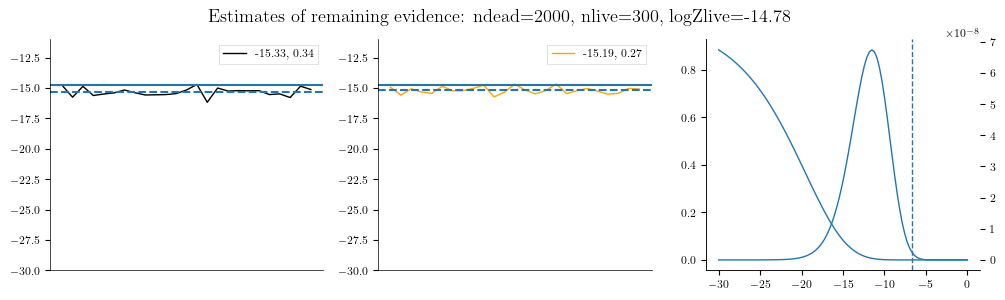

In [482]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 3))
ax1.plot(logZlive_meani, lw=1, color='black', label=f"{np.mean(logZlive_meani):.2f}, {np.std(logZlive_meani):.2f}")
ax1.axhline(y=np.mean(logZlive_meani), ls='--')
ax2.plot(logZlive_smoothi, lw=1, color='orange', label=f"{np.mean(logZlive_smoothi):.2f}, {np.std(logZlive_smoothi):.2f}")
ax2.axhline(y=np.mean(logZlive_smoothi), ls='--')


for ax in [ax1, ax2]:
    ax.axhline(np.log(Zlive_true))
    ax.set_ylim(-30, -11)
    ax.set_xticks([])
    ax.legend()

ax4 = plt.twinx(ax3)
logXarray = np.linspace(-30, 0, 100)
Xarray = np.exp(logXarray)
ax3.plot(logXarray, gaussian_L(Xarray, [10, 0.1]), lw=1)
ax4.plot(logXarray, gaussian_L(Xarray, [10, 0.1])*Xarray, lw=1)
ax4.axvline(x=logX_mean[ndead], ls='--', lw=1)
fig.suptitle(f"Estimates of remaining evidence: ndead={ndead}, nlive={nlive}, logZlive={np.log(Zlive_true):.2f}");

#### **Getting errorbars across ensemble**

In [532]:
ndead = 5000
nlive = 500
nk = nk_dead_live(nlive, ndead)
X_mean = X_mu(nk)
logX_mean = logX_mu(nk)
Zlive_true = quad(gaussian_L, 0, X_mean[ndead], [10, 0.1])[0]
Zlive_true, np.log(Zlive_true)

(3.0940147647880746e-07, -14.988626126747702)

In [533]:
nt = 20
logZlive_mean = np.zeros(nt)
logZlive_smooth = np.zeros(nt)
logZlive_mean_std = np.zeros(nt)
logZlive_smooth_std = np.zeros(nt)

for i in range(nt):
    Xtrue = generate_Xs(nk)
    logX = np.log(Xtrue)
    theta_true = [10, 0.1]
    logL = middle.func(Xtrue, theta_true)
    L = np.exp(logL)
    logLdead, logLlive = logL[:ndead], logL[ndead:]
    Ldead, Llive = np.exp(logLdead), np.exp(logLlive)
    logZlive_meani = []
    logZlive_smoothi = []
    for _ in range(25):
        X = generate_Xs(nk)
        logX = np.log(X)
        ls = LS(logL[ndead:], middle, X[ndead:])
        theta_l = ls.minimise(theta_true)
        Zlive_mean = evidence(Llive, X[ndead:])
        Zlive_smooth = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
        logZlive_meani.append(np.log(Zlive_mean))
        logZlive_smoothi.append(np.log(Zlive_smooth))

    logZlive_mean[i] = np.mean(logZlive_meani)
    logZlive_mean_std[i] = np.std(logZlive_meani)
    logZlive_smooth[i] = np.mean(logZlive_smoothi)
    logZlive_smooth_std[i] = np.std(logZlive_smoothi)

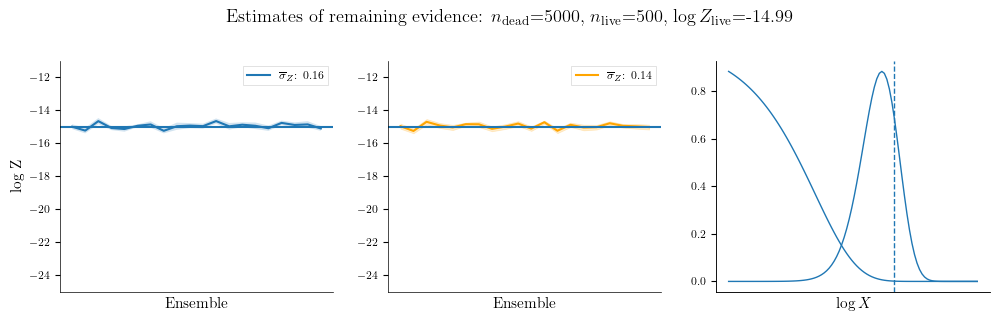

In [534]:
ensemble = np.arange(nt)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 3))
ax1.plot(ensemble, logZlive_mean, label=f"$\overline{{\sigma}}_Z$: {np.mean(logZlive_mean_std):.2f}")
ax1.fill_between(ensemble, logZlive_mean - logZlive_mean_std, logZlive_mean + logZlive_mean_std, alpha=0.2)
ax1.set_ylabel("log Z")

ax2.plot(ensemble, logZlive_smooth, color='orange', label=f'$\overline{{\sigma}}_Z$: {np.mean(logZlive_smooth_std):.2f}')
ax2.fill_between(ensemble, logZlive_smooth - logZlive_smooth_std, logZlive_smooth + logZlive_smooth_std, alpha=0.2, color='orange')

for ax in [ax1, ax2]:
    ax.axhline(np.log(Zlive_true))
    ax.set_ylim(-25, -11)
    ax.set_xticks([])
    ax.set_xlabel("Ensemble")
    ax.legend()

ax4 = plt.twinx(ax3)
logXarray = np.linspace(-30, 0, 100)
Xarray = np.exp(logXarray)
ax3.plot(logXarray, gaussian_L(Xarray, [10, 0.1]), lw=1)
ax3.set_xticks([])
ax3.set_xlabel(f"$\log X$")
ax4.set_yticks([])

ax4.plot(logXarray, gaussian_L(Xarray, [10, 0.1])*Xarray, lw=1)
ax4.axvline(x=logX_mean[ndead], ls='--', lw=1)

fig.suptitle(f"Estimates of remaining evidence: $n_\mathrm{{dead}}$={ndead}, $n_\mathrm{{live}}$={nlive}, $\log Z_\mathrm{{live}}$={np.log(Zlive_true):.2f}", y=1.05);

#### **Convergence across run**
$$\sigma^2_{Z_\mathrm{tot}} = \sigma^2_{Z_\mathrm{dead}} + \sigma^2_{Z_\mathrm{live}}$$

In [4]:
samples = samples_g_1
logL = samples_g_1.logL
logX = samples_g_1.logX()
Z0 = np.trapz(np.exp(logX), np.exp(logL))
np.log(Z0), samples_g_1.logZ()
Z0

4.0286141313446075e-07

##### For single iteration

In [763]:
ndead = 1500
logL_k = samples.iloc[ndead].logL
points = samples[samples.logL_birth < logL_k].recompute()
logLdead, logLlive = np.array(points.logL[:ndead]), np.array(points.logL[ndead:])
Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

nk = np.array(points.nlive)
logX_mean = logX_mu(nk)
X_mean = np.exp(logX_mean)

In [764]:
# Zdead
nt = 50
Zdead = np.zeros(nt)
for i in range(nt):
    Xdead = generate_Xs(nk[:ndead])
    Zdead[i] = evidence(Ldead, Xdead, live=False)
logZdead = np.log(Zdead)
# np.mean(logZdead), np.std(logZdead)
np.mean(Zdead), np.std(Zdead)

(2.6235569857170898e-14, 2.6823152901340833e-15)

In [768]:
# Zlive NORMAL
nt = 50
Zlive_normal = np.zeros(nt)
for i in range(nt):
    Xlive = generate_Xs(nk)[ndead:]
    Zlive_normal[i] = evidence(Llive, Xlive)
logZlive_mean = np.log(Zlive_normal)
# np.mean(logZlive), np.std(logZlive)
np.mean(Zlive_normal), np.std(Zlive_normal)

(5.0403538362306145e-08, 1.508196120770843e-08)

In [769]:
# Zlive SMOOTH
nt = 50
Zlive_smooth = np.zeros(nt)
for i in range(nt):
    Xlive = generate_Xs(nk)[ndead:]
    ls = LS(logLlive, middle, Xlive)
    theta_l = ls.minimise(theta_true)
    Zlive_smooth[i] = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
logZlive_mean = np.log(Zlive_smooth)
# np.mean(logZlive), np.std(logZlive)
np.mean(Zlive_smooth), np.std(Zlive_smooth)

(3.4792211953435716e-07, 1.3795449960907297e-07)

In [772]:
Zdead_var = np.var(Zdead)
Znormal = np.mean(Zdead) + np.mean(Zlive_normal)
Znormal_std = np.sqrt(Zdead_var + np.var(Zlive_normal))
Zsmooth = np.mean(Zdead) + np.mean(Zlive_smooth)
Zsmooth_std = np.sqrt(Zdead_var + np.var(Zlive_smooth))

##### Across all iterations

In [5]:
from aeons.toy_samples import gaussian_samples

In [29]:
samples100 = gaussian_samples(nlive=500, ndims=10, sigma=0.1)
theta_true = [10, 0.1]

In [30]:
samples = samples100
iterations = np.arange(100, 6000, 100)
Nk = len(iterations)

logL = samples.logL
logX = samples.logX()
Z0 = np.trapz(np.exp(logX), np.exp(logL))
np.log(Z0), samples.logZ()
# Z0

(-14.724673222146587, -14.724673222146617)

In [31]:
Znormal = np.zeros(Nk)
Znormal_std = np.zeros(Nk)
Zsmooth = np.zeros(Nk)
Zsmooth_std = np.zeros(Nk)

for k, ndead in enumerate(iterations):
    logL_k = samples.iloc[ndead].logL
    points = samples[samples.logL_birth < logL_k].recompute()
    logLdead, logLlive = np.array(points.logL[:ndead]), np.array(points.logL[ndead:])
    Ldead, Llive = np.exp(logLdead), np.exp(logLlive)

    nk = np.array(points.nlive)
    logX_mean = logX_mu(nk)
    X_mean = np.exp(logX_mean)

    # Zdead
    nt = 25
    Zdead = np.zeros(nt)
    for i in range(nt):
        Xdead = generate_Xs(nk[:ndead])
        Zdead[i] = evidence(Ldead, Xdead, live=False)
    logZdead = np.log(Zdead)

    # Zlive NORMAL
    nt = 25
    Zlive_normal = np.zeros(nt)
    for i in range(nt):
        Xlive = generate_Xs(nk)[ndead:]
        Zlive_normal[i] = evidence(Llive, Xlive)
    logZlive_mean = np.log(Zlive_normal)

    # Zlive SMOOTH
    nt = 25
    Zlive_smooth = np.zeros(nt)
    for i in range(nt):
        Xlive = generate_Xs(nk)[ndead:]
        ls = LS(logLlive, middle, Xlive)
        theta_l = ls.minimise(theta_true)
        Zlive_smooth[i] = quad(gaussian_L, 0, X_mean[ndead], theta_l)[0]
    logZlive_mean = np.log(Zlive_smooth)

    Zdead_var = np.var(Zdead)
    Znormal[k] = np.mean(Zdead) + np.mean(Zlive_normal)
    Znormal_std[k] = np.sqrt(Zdead_var + np.var(Zlive_normal))
    Zsmooth[k] = np.mean(Zdead) + np.mean(Zlive_smooth)
    Zsmooth_std[k] = np.sqrt(Zdead_var + np.var(Zlive_smooth))

In [26]:
logZan = np.zeros(Nk)
for k, ndead in enumerate(iterations):
    logL_k = samples.iloc[ndead].logL
    points = samples[samples.logL_birth < logL_k].recompute()
    logZan[k] = points.logZ()

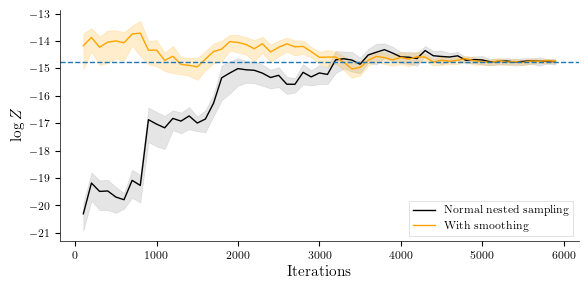

In [36]:
plt.figure(figsize=(6.7, 3))
plt.plot(iterations, np.log(Znormal), color='black', lw=1, label="Normal nested sampling")
# plt.plot(iterations, logZan, color='deepskyblue', label="Anesthetic")
plt.fill_between(iterations, np.log(Znormal+Znormal_std), np.log(Znormal-Znormal_std), color='gray', alpha=0.2)
plt.plot(iterations, np.log(Zsmooth), lw=1, color='orange', label="With smoothing")
plt.fill_between(iterations, np.log(Zsmooth + Zsmooth_std), np.log(Zsmooth-Zsmooth_std), color='orange', alpha=0.2)
plt.axhline(y=-14.75, lw=1, ls='--')
plt.xlabel("Iterations");
plt.ylabel("$\log Z$");
plt.legend(loc="lower right");
plt.savefig('../../../report/figures/Z_smooth_vs_normal.pdf', format='pdf', bbox_inches='tight')

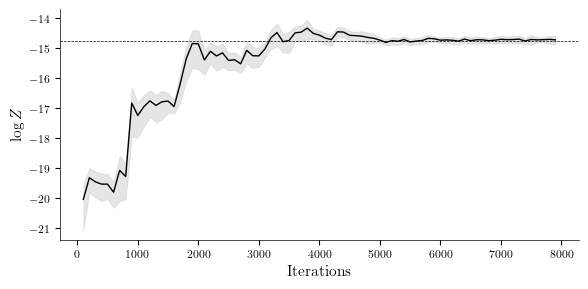

In [24]:
plt.figure(figsize=(6.7,3))
plt.plot(iterations, np.log(Znormal), label="Normal nested sampling", color='black', lw=1)
plt.fill_between(iterations, np.log(Znormal+Znormal_std), np.log(Znormal-Znormal_std), alpha=0.2, color='gray')
plt.axhline(y=-14.75, lw=.5, ls='--', color='black')
plt.xlabel("Iterations");
plt.ylabel("$\log Z$");
plt.savefig('../../../report/figures/Z_normal_NS.pdf', format='pdf', bbox_inches='tight')